# Machine Learning Engineer Nanodegree - Capstone Project
## PART 1: EDA and Data preprocessing

**Author:** Giacomo Sarchioni

## Module imports

In [3]:
# Import modules for this notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import cm
import pickle as pkl
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.stats import describe
import re
from sklearn.model_selection import StratifiedShuffleSplit

# Define random seed (if any)
random_seed = 42

## Load original data

Since the file containing the original data is very large, I was not able to upload it to GitHub (given the 100.0 MB size limit). The file I have used can be downloaded here: https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/amazon-fine-food-reviews.zip/2.

Please unzip the folder and use the `Reviews.c

In [4]:
# Load original reviews data
reviews = pd.read_csv('reviews/original_data/amazon_fine_food_reviews.csv')

In [5]:
# Print reviews' shape
print(reviews.shape)

(568454, 10)


In [6]:
# Pretty-print columns
pprint(list(reviews.columns))

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']


In [7]:
# Sample data
reviews.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


## Duplicates

In [8]:
# Extract text duplicates
duplicates = reviews[reviews.duplicated('Text')].copy()
duplicates.sort_values(by='Text', inplace=True)
duplicates.shape

(174875, 10)

In [9]:
# Print sample of duplicated reviews
reviews[reviews.Text==duplicates.iloc[3,:].Text]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
184223,184224,B006ZC3IHY,A17950SQVNAVOD,Scott,0,0,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."
225579,225580,B002ZX1U9A,A17950SQVNAVOD,Scott,2,2,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."
233264,233265,B007TJGZ4A,A17950SQVNAVOD,Scott,2,2,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."
245224,245225,B0029XDZKI,A17950SQVNAVOD,Scott,2,2,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."
425981,425982,B000TQEWM2,A17950SQVNAVOD,Scott,2,2,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."
473106,473107,B008FHUKE6,A17950SQVNAVOD,Scott,2,2,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."
519542,519543,B006N3I1HM,A17950SQVNAVOD,Scott,2,2,1,1313625600,Packaging quality problem,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill..."


In [10]:
# Remove duplicates by Text only
reviews_no_dupl = reviews.drop_duplicates(subset='Text')
reviews_no_dupl.reset_index(inplace=True, drop=True)

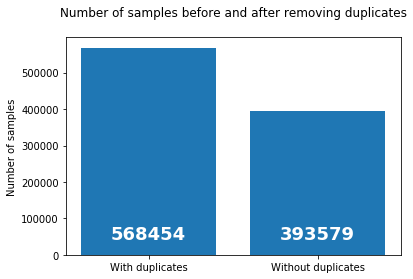

In [11]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
bars = ax.bar(range(2), [reviews.shape[0], reviews_no_dupl.shape[0]])
ax.set_ylabel('Number of samples')
ax.set_title('Number of samples before and after removing duplicates\n')
ax.set_xticks([0,1])
ax.set_xticklabels(['With duplicates', 'Without duplicates'])

height = bars[0].get_height()

for i in bars:
    ax.text(i.get_x() + i.get_width()/2., 0.1*height,
            '%d' % int(i.get_height()),
            ha='center', va='center',
            fontsize=18,
            fontweight='bold',
            color='white')

plt.show();

### EDA - `Text`

In [12]:
# Calculate reviews' length stats
reviews_length = np.array([len(x) for x in reviews_no_dupl.loc[:,'Text'].values])
reviews_stats = describe(reviews_length)

print('Average length of reviews is {:.0f} characters'.format(reviews_stats.mean))
print('The shortest review has {:.0f} characters'.format(reviews_stats.minmax[0]))
print('The longerst review has {:.0f} characters'.format(reviews_stats.minmax[1]))

Average length of reviews is 434 characters
The shortest review has 12 characters
The longerst review has 21409 characters


The boxplot of reviews' lenght distributions shows a pretty high number of outliers.

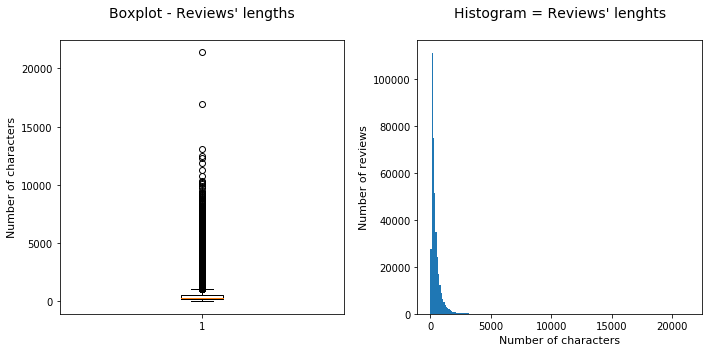

In [13]:
# Plotting
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.boxplot(reviews_length)
ax1.set_ylabel("Number of characters", fontsize=11)
ax1.set_title("Boxplot - Reviews' lengths\n", fontsize=14)


ax2 = fig.add_subplot(122)
ax2.hist(reviews_length, bins=200)
ax2.set_title("Histogram = Reviews' lenghts\n", fontsize=14)
ax2.set_xlabel('Number of characters', fontsize=11)
ax2.set_ylabel('Number of reviews', fontsize=11)

plt.tight_layout();

### EDA - `Score`

In [14]:
# Calculate the percentage of reviews by score with and without duplicated reviews
perc_by_score_with_dupl = reviews.groupby('Score').count() / reviews.shape[0]
perc_by_score_wout_dupl = reviews_no_dupl.groupby('Score').count() / reviews_no_dupl.shape[0]

In [15]:
perc_by_score_wout_dupl.Id*100

Score
1     9.216701
2     5.282802
3     7.559855
4    14.239073
5    63.701569
Name: Id, dtype: float64

In [16]:
# Get data for plots
composition_data = []
for data in [perc_by_score_with_dupl, perc_by_score_wout_dupl]:
    idx = data.index.get_values()
    values = data.Text.values
    composition_data.append([idx,values])

In [17]:
# Define color map
color_map = cm.RdBu(np.array(composition_data[0][0])/np.array(composition_data[0][0]).max())

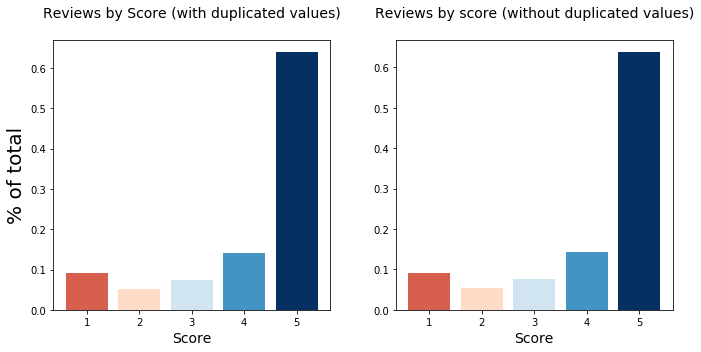

In [18]:
# Plotting
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.bar(composition_data[0][0], composition_data[0][1], color=color_map)
ax1.set_xlabel('Score', fontsize=14)
ax1.set_ylabel('% of total', fontsize=20)
ax1.set_title('Reviews by Score (with duplicated values)\n', fontsize=14)


ax2 = fig.add_subplot(122)
ax2.bar(composition_data[1][0], composition_data[1][1], color=color_map)
ax2.set_title('Reviews by score (without duplicated values)\n', fontsize=14)
ax2.set_xlabel('Score', fontsize=14)

plt.tight_layout();

##### Relation between lenght of a review and sentiments (unprocessed data)

In [19]:
def extract_data_for_review_length_boxplot(dataframe, group_key, value_key):
    
    """
    
        This function is used to extract data for plotting a series of boxplot
        for different values of a categorical variable.
        
        Args:
            - dataframe: a pandas dataframe
            - group_key: a string, specifying the key used to group the dataframe
            - value_key: a string, specifying the column on which to calculate a string's length
            
        Returns:
            - (key_values, data_values): a tuple, including the unique values for the
                                         group key (key_values) and the associated values
                                         per key (data_values)
    
    """
    
    # Initialise the two list
    key_values = []
    data_values = []
    
    # Loop through the grouped dataframe and append keys and values
    for key, key_df in dataframe.groupby(group_key):
        key_values.append(key)
        data_values.append(key_df.loc[:,value_key].apply(lambda x: len(x)))
        
    # Return tuple
    return (key_values, data_values)

In [20]:
# Extract score and score_values
scores, score_values = extract_data_for_review_length_boxplot(reviews_no_dupl, 'Score', 'Text')

/Users/gsarchioni/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


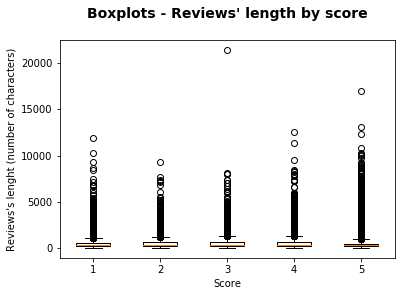

In [21]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.boxplot(score_values)
ax.set_xticks(scores)
ax.set_ylabel("Reviews's lenght (number of characters)")
ax.set_title("Boxplots - Reviews' length by score\n", fontsize=14, fontweight='bold')
ax.set_xlabel('Score');

In [22]:
# Extract 75th percentile of all reviews' lenghts
reviews_length_all = reviews_no_dupl.Text.apply(lambda x: len(x))
percentile = np.percentile(reviews_length_all.values, 75)

In [23]:
# Extract data for boxplots
reviews_no_dupl_perc = reviews_no_dupl[reviews_length_all<=percentile]
scores_perc, score_values_perc = extract_data_for_review_length_boxplot(reviews_no_dupl_perc, 'Score', 'Text')

/Users/gsarchioni/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


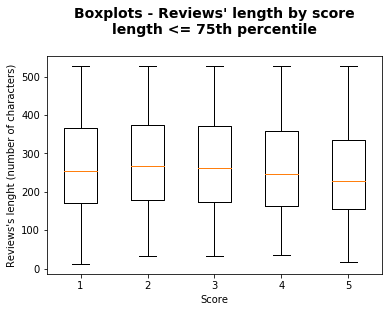

In [24]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.boxplot(score_values_perc)
ax.set_xticks(scores_perc)
ax.set_ylabel("Reviews's lenght (number of characters)")
ax.set_title("Boxplots - Reviews' length by score\nlength <= 75th percentile\n", fontsize=14, fontweight='bold')
ax.set_xlabel('Score');

## Text Pre-processing

Raw text data is pretty noisy. There could be HTML tags, capital letters, punctuations, etc. If we define text by words, in fact, `"good"` and `"Good"` would actually be perceived as **two different words** while we know they are not.  
As described in the Capstone Proposal document, I will apply a series of data processing techniques to all the reviews. Such processing include the following:

* Remove HTML tags and other HTML text (if any)
* Transform all text in lower case
* Keep letter characters only (remove numbers, special characters and punctuation)
* Remove English stopwords (e.g. "the", "of", "and", etc.)
* Remove leading and trailing whitespaces.

I will also add an optional pre-processing procedude called *stemming*.  
  
For such text processing activities, in addition to common modules available in the Anaconda install, I will also use the *natural language toolkit* module (`nltk`) and *BeautifulSoup*.  
Let me go through a **detailed example** for a single review. I will then create a generic function that performs parsing.

In [25]:
# Choose a test review
test_review = reviews_no_dupl.iloc[0,-1]
print(test_review)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


##### Remove HTML Tags 
Removing HTML text can simply be achieved by using a famous Python library called `BeautifulSoup`. Such library has been designed to work with HTML text. By using the `get_text()` function on a string parsed with BeautifulSoup we are able to remove any HTML-specific combination of character (e.g. &lt;a&gt;, &lt;div&gt;, etc.).

In [26]:
test_review = BeautifulSoup(test_review, 'lxml').get_text()
print(test_review)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


At first sight, the parsed review looks exactly like before. This is because the origianl review did not have HTML tags. Let's do a quick example.§

In [27]:
html_review = '<a>Fantastic food</a>'
print(html_review)

<a>Fantastic food</a>


In [28]:
# Parsing with BeautifulSoup
print(BeautifulSoup(html_review,'lxml').get_text())

Fantastic food


`BeautifulSoup` has removed all HTML-specific text.

##### Transform all text in lower case

In [29]:
test_review = test_review.lower()
print(test_review)

i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.


##### Keep letter characters only
Keeping letter characters only is very easy using **regular expression**. Such processing will remove numbers, special characters (e.g. `$`) and punctuation.

In [30]:
test_review = re.sub('[^a-zA-Z]'," ", test_review)
print(test_review)

i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 


##### Remove English stopwords
*In computing, stop words are words which are filtered out before or after processing of natural language data (text). Though "stop words" usually refers to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list* ([Wikipedia](https://en.wikipedia.org/wiki/Stop_words)).  
  
The package I use here is called `nltk` and it is a pretty standard package used for natural language processing in Python. `nltk` contains a corpus of stopwords. I will extract those for the English language.

In [31]:
eng_stopwords = set(stopwords.words('English'))
print(eng_stopwords)

{'was', 'don', 'its', 'them', 'they', 'further', 'nor', 'doesn', "mustn't", 'yours', 'and', 'all', "wasn't", 'because', 'weren', 'just', "haven't", "didn't", 'here', 'him', 'her', 'be', 're', 'am', 'while', 'any', 'most', 'before', 'o', 'isn', 'it', 'as', 'you', 'an', 'over', 'your', 'the', 'themselves', 'but', "it's", 'shouldn', 'now', 'a', 'haven', 'through', "shan't", 'has', 'in', 'same', 'couldn', 'my', 'those', "mightn't", 'we', 'his', "that'll", 'should', 'these', 'of', "shouldn't", 'which', 'into', 'who', 'ourselves', "aren't", 'how', 'itself', 'ain', 'for', 'where', "doesn't", 'from', "should've", 'aren', 'under', 'll', "won't", 'theirs', 'once', 'can', 'hers', 'at', 'are', 'himself', 'when', 'won', 'other', 'below', "don't", 'out', 'had', 'mightn', 'by', "wouldn't", 'above', 'no', 'until', 'then', 'about', 'wouldn', 'whom', 'why', "you'll", 'very', 'he', 's', 'off', 'this', "weren't", 'yourselves', 'if', 'against', 'ma', 'do', "you'd", 'to', 'didn', 'have', 'were', 'herself', 

To remove such stopwords I need to:

* split my review into words;
* loop through the list of words in the review and keep only those that are not in the stopwords set. I will also make sure to remove any empty space (i.e. the character "").  
  
For comparison purposes, I am going to keep an old version of the test review called `old_test_review'.

In [78]:
old_test_review = test_review

# Split test_reviews
new_test_review = test_review.split(" ")

# Remove empty spaces
new_test_review = [w for w in new_test_review if w != ""]

# Remove stopwords
new_test_review = [w for w in new_test_review if w not in eng_stopwords]

# Rejoin words
new_test_review = " ".join(new_test_review)

In [79]:
print("The review before removing stopwords was:\n{}".format(old_test_review))
print("\nThe review after removing stopwords was:\n{}".format(new_test_review))

The review before removing stopwords was:
i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

The review after removing stopwords was:
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better


In [80]:
" ".join(old_test_review.split())

'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most'

As you can see, the `new_test_review`, i.e. the review after having removed the stopwords, is a much shorter sentence, where stopwords have been removed.  
In `new_test_review`, the origianl text *"have found them all to be of good quality"* has now been replaced with *"found good quality"*. From a sentiment analysis perspective, this is actually pretty good, since we have removed words which, in terms of sentiment, were not adding any value and could have biased our model. 

##### Remove leading and trailing whitespaces
Remove leading and trailing whitespaces is performed easily by using the `strip()` built-in Python method.

In [81]:
new_test_review = new_test_review.strip()

##### Stemming (optional)
Stemming is another text preprocessing technique. It, as the name suggests, stems words so that two words with the same root are actually represented in the same way. For example, a stemmer would make the words *"beautiful"* and *"beauty"* look the same (more info [here](https://en.wikipedia.org/wiki/Stemming)).  
In `nltk` there are multiple stemmers available. I will use the Porter's stemmer, a widely used stemmer in natural language processing. 

In [82]:
st = PorterStemmer()
stem_test_review = " ".join([st.stem(w) for w in new_test_review.split(" ")])
stem_test_review

'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better'

As you can see, some of the final letters in some words have been removed (e.g. *several* becomes *sever*, *appreciates* become *appreci*. This technnique may furthere reduce noise in our text data. I will test it later on and check if adding stemming does contribute to some improvement in performance. 

Let me now create a function that performs all of the parsing options. Using a almost functional-programming syntax, I will create the single parsing functions and I will pass them as a list of instructions to an overall `parse_review` function

In [87]:
# Define global parameters
stopwords_set = stopwords.words('english')
stemmer = PorterStemmer()

# Remove HTML tags
def remove_html_tags(review):
    
    """
    
        This function takes a string as an input and return it
        after having remove all HTML tags, using BeautifulSoup
        
        Args:
            - review: a string
            
        Return:
            - a string after having remove HTML tags
    
    """
    
    return BeautifulSoup(review, 'lxml').get_text()


# Make lower case
def make_lower_case(review):
    
    """
    
        This function takes a string as an input and return it
        after having made all text lower case.
        
        Args:
            - review: a string
            
        Return:
            - a string after having made all lower case
    
    """
    
    return review.lower()


# Keep letter characters only
def keep_letters_only(review):
    
    """
    
        This function takes as a string as an input and replace
        all non-letter characters with a blank space.
        
        Args:
            - review: a string
            
        Return:
            - a string containing only letter characters
    
    """

    return re.sub('[^a-zA-Z]'," ", review)
    

# Remove stopwords
def remove_stopwords(review):
    
    """
    
        This function takes as string as an input and remove
        all words which are beloging to the stopword set.
        
        Args:
            - review: a string
            
        Returns:
            - a string after having removed all stopwords
    
    """
    
    # Split review
    review = review.split(" ")
    
    # Remove empty spaces
    review = [w for w in review if w != ""]
    
    # Remove stopword
    review = [w for w in review if w not in stopwords_set]
    
    return " ".join(review)


# Stem review
def stem_review(review):
    
    """
    
        This function takes as string as an input and
        stem all its words.
        
        Args:
            - review: a string
            
        Returns:
            - a string after having stemmed all the words
    
    """
    
    # Split review
    review = review.split(" ")
    
    # Remove empty spaces
    review = [w for w in review if w != " "]
    
    # Stem
    review = [stemmer.stem(w) for w in review]
    
    return " ".join(review)


# Remove leading and trailing whitespaces
def remove_white_spaces(review):
    
    """
    
        This function takes as a string as an input and remove
        leading and trailing whitespaces.
        
        Args:
            - review: a string
            
        Returns:
            - a string after having removed leading and trailing whitespaces
    
    """
    
    # Removin leading and trailing white spaces
    review = review.strip()
    
    # Split review
    review = review.split(" ")
    
    # Remove empty spaces
    review = [w for w in review if w != " "]
    
    return " ".join(review)

I will now define a `parse_review` function that takes a review and list of parsing functions (from the one defined above) as input in order to transform the review itself.

In [88]:
def parse_review(review, parsing_functions):
    
    """
    
        This function takes a string as an input and returns
        the string after having applied a list of parsing functions.
        
        Args:
            - review: a string
            - parsing_functions: a list
            
        Returns:
            - a string after having applied the parsing functions
    
    """
    
    for f in parsing_functions:
        review = f(review)
        
    return review

In [89]:
# Get an example
example = reviews_no_dupl.iloc[192,-1]
print(example)

These little guys are tasty and refreshing.<br /><br />I usually eat salads for lunch which can do terrible things to breath.  I eat 2 of these after lunch (because they are so small) and I find this sufficiently resolves the problem.<br /><br />They're sugar free (sugar can actually help the smelly bacteria grow) which is great and they're tasty enough that I almost think of them as part of my lunch.<br /><br />This is a good bulk value buy and I'd highly recommend the mints themselves.  Cheers!


In [90]:
parse_review(example, [remove_html_tags, make_lower_case, keep_letters_only, remove_stopwords, remove_white_spaces])

'little guys tasty refreshing usually eat salads lunch terrible things breath eat lunch small find sufficiently resolves problem sugar free sugar actually help smelly bacteria grow great tasty enough almost think part lunch good bulk value buy highly recommend mints cheers'

##### Parse reviews

Let me now add parsed reviews to my dataframe

In [91]:
from tools.review_parser import *

In [92]:
# NO HTML, LOWER, NO LEADING AND TRAILING WHITESPACES
parser_zero = [remove_html_tags, make_lower_case, remove_white_spaces]

# NO HTML, LOWER, LETTERS-ONLY, NO LEADING AND TRAILING WHITESPACES
parser_one = [remove_html_tags, make_lower_case, keep_letters_only, remove_white_spaces]

# NO HTML, LOWER, LETTERS-ONLY, NO STOPWORDS, NO LEADING AND TRAILING WHITESPACES
parser_two = [remove_html_tags, make_lower_case, keep_letters_only, remove_stopwords, remove_white_spaces]

# NO HTML, LOWER, LETTERS-ONLY, NO STOPWORDS, STEMMED, NO LEADING AND TRAILING WHITESPACES
parser_three = [remove_html_tags, make_lower_case, keep_letters_only, remove_stopwords, stem_review, remove_white_spaces]

In [93]:
# Create a new dataframe
parsed_reviews = reviews_no_dupl.copy()

In [94]:
# Apply parser_zero
parsed_reviews.loc[:,'parser_zero'] = parsed_reviews.loc[:,'Text'].apply(parse_review, args=(parser_zero,)) 

In [95]:
# Apply parser_one
parsed_reviews.loc[:,'parser_one'] = parsed_reviews.loc[:,'Text'].apply(parse_review, args=(parser_one,)) 

In [96]:
# Apply parser_two
parsed_reviews.loc[:,'parser_two'] = parsed_reviews.loc[:,'Text'].apply(parse_review, args=(parser_two,)) 

In [97]:
# Apply parser_three
parsed_reviews.loc[:,'parser_three'] = parsed_reviews.loc[:,'Text'].apply(parse_review, args=(parser_three,)) 

Perfect. Let me now check an example.

In [98]:
example = parsed_reviews.iloc[0,:]
print("Original text")
print(example.Text)
print("\nParser zero text")
print(example.parser_zero)
print("\nParser one text")
print(example.parser_one)
print("\nParser two text")
print(example.parser_two)
print("\nParser three text")
print(example.parser_three)

Original text
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Parser zero text
i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.

Parser one text
i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most

Parser two text
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appre

##### Remove empty reviews
Because of applyting the above parsing function, some of the reviews may now contain no text at all. For example, if review had been made of numbers and/or special characters only, *parser_two* and *parser_three* would have returned an empty string. Such text data would not really help me to predict any sentiment, so it is better to remove it.  
  
Let me check how many reviews have now a *parser_two* text equal to `""`.

In [99]:
parsed_reviews[parsed_reviews.parser_two==""]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,parser_zero,parser_one,parser_two,parser_three
186041,233939,B003E6COMO,A2ZE58VIDDCMR7,inna,1,2,5,1350000000,&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...,&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1...,"решила заказать эти желатинки, т.к. дочка пошл...",,,


**Luckily**, there is only one of such reviews. Let me remove it.

In [100]:
parsed_reviews = parsed_reviews[parsed_reviews.parser_two != ""].copy()
parsed_reviews.reset_index(drop=True, inplace=True)
parsed_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,parser_zero,parser_one,parser_two,parser_three
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled jumbo salted peanuts p...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...,this is a confection that has been around a fe...,confection around centuries light pillowy citr...,confect around centuri light pillowi citru gel...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...,great taffy at a great price there was a wid...,great taffy great price wide assortment yummy ...,great taffi great price wide assort yummi taff...


Let me save the reviews into four different pickle files.

### Score
Let me convert negative *Score* reviews (1 and 2) into 0, and positive *Score* reviews (4 and 5) into 1.

In [101]:
parsed_reviews.loc[:,'adj_score'] = parsed_reviews.loc[:,'Score'].apply(lambda x: 1.0 if x >= 4 else 0.0 if x <=2 else 3.0)

In [102]:
parsed_reviews.shape

(393578, 15)

In [103]:
parsed_reviews.adj_score.value_counts(normalize=True)

1.0    0.779406
0.0    0.144995
3.0    0.075599
Name: adj_score, dtype: float64

##### Save data

In [104]:
neutral_reviews = parsed_reviews[parsed_reviews.adj_score==3.0]
sentiment_reviews = parsed_reviews[parsed_reviews.adj_score!=3.0]

In [105]:
with open('reviews/neutral_reviews/neutral.pkl', 'wb') as f:
    pkl.dump(neutral_reviews, f)

with open('reviews/sentiment_reviews/sentiment.pkl', 'wb') as f:
    pkl.dump(sentiment_reviews, f)

## Train, Validation and Test Split
Most of the sentiment reviews - slightly more than 84% - belong to the positve sentiment class (i.e. `adj_score` value equal to 1.0).

In [106]:
sentiment_reviews.adj_score.value_counts(normalize=True)

1.0    0.843147
0.0    0.156853
Name: adj_score, dtype: float64

In [107]:
# Create a Stratified Shuffle Splitter to split my data
SSS = StratifiedShuffleSplit(n_splits=1, random_state=random_seed)

In [108]:
# Extract data labels
y = sentiment_reviews.adj_score.values

# Extract non-test and test indexes
for i, j in SSS.split(np.zeros(y.shape), y):
    non_test_idx = i
    test_idx = j
    
y_non_test = y[non_test_idx]

for i, j in SSS.split(np.zeros(y_non_test.shape), y_non_test):
    train_idx = i
    val_idx = j

Please notice that train and validation indexes must be used on the non_test data. In other words, you cannot use the `train_idx` to slice the `sentiment_reviews` dataframe straight away, but you have to slice it first with the `non_test_idx`

In [109]:
# Proportion of reviews by sentiment for non_test data
sentiment_reviews.iloc[non_test_idx,:].adj_score.value_counts(normalize=True)

1.0    0.843147
0.0    0.156853
Name: adj_score, dtype: float64

In [110]:
# Proportion of reviews by sentiment for test data
sentiment_reviews.iloc[test_idx,:].adj_score.value_counts(normalize=True)

1.0    0.843141
0.0    0.156859
Name: adj_score, dtype: float64

In [111]:
# Proportion of reviews by sentiment for train data
sentiment_reviews.iloc[non_test_idx,:].iloc[train_idx,:].adj_score.value_counts(normalize=True)

1.0    0.843147
0.0    0.156853
Name: adj_score, dtype: float64

In [112]:
# Proportion of reviews by sentiment for validation data
sentiment_reviews.iloc[non_test_idx,:].iloc[val_idx,:].adj_score.value_counts(normalize=True)

1.0    0.843152
0.0    0.156848
Name: adj_score, dtype: float64

In [113]:
##### Save indexes
indexes = {"non_test" : non_test_idx, 
           "test" : test_idx, 
           "train" : train_idx, 
           "val" : val_idx}

In [114]:
with open("split_indexes/indexes.pkl", 'wb') as f:
    pkl.dump(indexes, f)